In [6]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 4s (1,327 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [0]:
import pytesseract
import shutil
import os
import random
import tempfile
import numpy as np
import imutils 

try:
 from PIL import Image
except ImportError:
 import Image

In [0]:
import cv2
import matplotlib.pyplot as plt

In [0]:
def get_string(st):
  img = cv2.imread(st, 0) #leer en escala de gris
  print(img.shape)
  plt.axis("off")
  plt.imshow(img, cmap = "gray") #hacer que el plt sepa que es una img en escala de grises
  plt.show()
  image_path_in_colab= st
  return pytesseract.image_to_string(Image.open(image_path_in_colab)), img

In [0]:
def set_image_dpi(file_path): #scale image
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return temp_filename

DPI describes the resolution of the image or in other words, it denotes printed dots per inch.

In [0]:
im = set_image_dpi("dni1.jpg")

(569, 940)


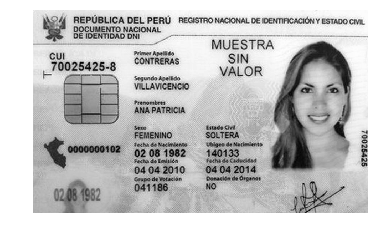

REPUBLICA DEL PERU REGISTRO NACIONAL DE IDENTIFICACION Y ESTADO cv
DOCUMENTO NACIONAL
DE IDENTIDAD DNi

  

ail ~ MUESTRA
cul SIN
70025425-8 CONTRERAS
‘3 colin: VALOR

VILLAVICENCIO

Prenombres

ANA PATRICIA

SzZPr9Z00

o000000102 OS an igao.
ye Fecha de Emulsion
Grupo de Voracion


In [120]:
texto, img = get_string(im)
print(texto)

In [0]:
def filtering_Median(image, size): #nonlinear filtering
  sr = int(size/2)
  sc = int(size/2)
  
  ir = image.shape[0]
  ic = image.shape[1]
  
  ni = np.zeros((ir + 2*sr, ic + 2*sc), np.float32)
  ni[sr:sr + ir, sc: sc + ic] = image
  
  ans = np.zeros(ni.shape)
  
  for i in range(sr, sr + ir):
    for j in range(sc, sc + ic):
      aux = ni[i - sr: sr + i + 1, j - sc: sc + j + 1]
      val = np.sort(aux.flatten())
      ans[i,j] = val[(size*size)//2]
  return ans[sr: sr + ir, sc: sc + ic].astype('uint8')

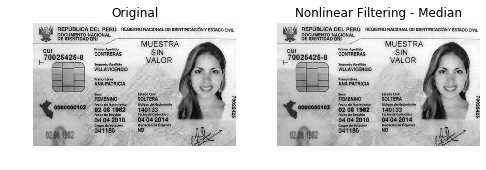

In [113]:
img_smooth = filtering_Median(img, 3)
plt.figure(figsize=[8,6])
plt.subplot(1,2,1), plt.imshow(img, cmap = "gray") , plt.axis("off"), plt.title("Original")
plt.subplot(1,2,2), plt.imshow(img_smooth, cmap = "gray"), plt.axis("off"), plt.title("Nonlinear Filtering - Median")
plt.show()

Median filtering is a nonlinear method used to remove noise from images

In [0]:
def normalized_histogram(img):
  H = np.zeros((256))
  for i in range(0, img.shape[0]):
    for j in range(0, img.shape[1]):
      H[img[i,j]] += 1
  H = H/(img.shape[0]*img.shape[1])
  return H

def equalize(img):
  h = normalized_histogram(img)
  A = np.zeros((256))
  A[0] = h[0]
  for i in range(1, 256):
    A[i] = A[i-1] + h[i]
  Out = np.zeros(img.shape)
  for i in range(0, img.shape[0]):
    for j in range(0, img.shape[1]):
      Out[i,j] = A[img[i,j]]
  return (255*Out).astype('uint8')

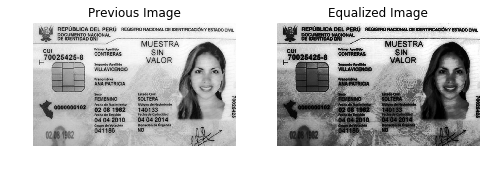

In [114]:
img_equalized = equalize(img_smooth)
plt.figure(figsize=[8,6])
plt.subplot(1,2,1), plt.imshow(img_smooth, cmap = "gray") , plt.axis("off"), plt.title("Previous Image")
plt.subplot(1,2,2), plt.imshow(img_equalized, cmap = "gray"), plt.axis("off"), plt.title("Equalized Image")
plt.show()

Histogram equalization is a more sophisticated technique, modifying the dynamic range of an image by altering the pixel values, guided by the intensity histogram of that image

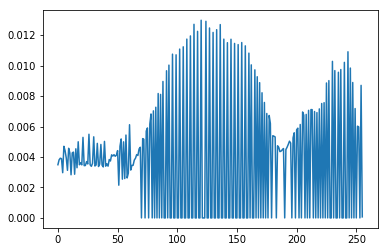

In [115]:
h = normalized_histogram(img_equalized)
plt.plot(h)
plt.show()

In [81]:
!pip install imutils

In [0]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped
  
def rotate_image(image):
  image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  edged = cv2.Canny(gray, 10, 50)
  cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if imutils.is_cv2() else cnts[1]
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
  screenCnt = None
  for c in cnts:
      peri = cv2.arcLength(c, True)
      approx = cv2.approxPolyDP(c, 0.02 * peri, True)
      if len(approx) == 4:
          screenCnt = approx
          break
  if(screenCnt == None):
    return img
  pts = np.array(screenCnt.reshape(4, 2) * ratio)
  warped = four_point_transform(orig, pts)
  return warped

In [0]:
def print_image(img1, img2, str1, str2):
  plt.figure(figsize=[8,6])
  plt.subplot(1,2,1), plt.imshow(img1, cmap = "gray") , plt.axis("off"), plt.title(str1)
  plt.subplot(1,2,2), plt.imshow(img2, cmap = "gray"), plt.axis("off"), plt.title(str2)
  plt.show()

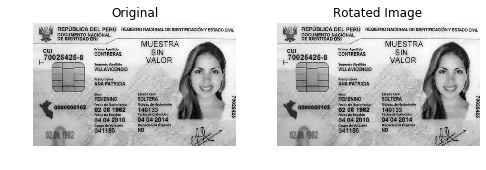

In [116]:
img_final = rotate_image(img)
print_image(img, img_final, "Original", "Rotated Image")

In [0]:
def cut_image(img, x, y, h, w):
  return img[y:y+h, x:x+w]

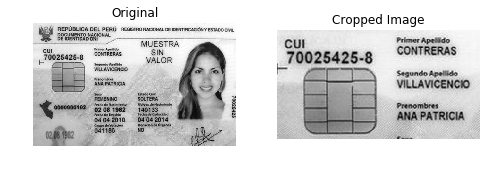

In [224]:
img = cv2.imread('dni1.jpg', 0)
img_cut = cut_image(img, 30, 100, 230, 430)
print_image(img, img_cut, "Original", "Cropped Image")

In [225]:
img1 = img_cut
texto = pytesseract.image_to_string(img1)
print(texto)

50025425-8

 

Primer Apettido
CONTRERAS

Segundo Apeilido
VILLAVICENCIO

Prenombres
ANA PATRICIA


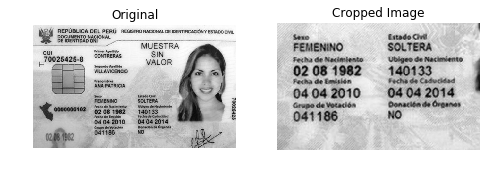

In [226]:
img = filtering_Median(cv2.imread('dni1.jpg', 0), 3)
img_cut = cut_image(img, 250, 300, img.shape[1] - 300, 430)
print_image(img, img_cut, "Original", "Cropped Image")

In [227]:
texto = pytesseract.image_to_string(img2)
print(texto)

Sexo
FEMENINO
Fecha de Nacimiento

02 08 1982
04 04 2010

Grape de Wotacion

041186

Estado Ov
Ubiges de Nacinsento
140133

Fecha de Caducised
04 04 2014

Oonacion de Organos
